In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import random
from collections import defaultdict
from sklearn.metrics import f1_score

In [2]:
def load_data():
    data=pd.read_csv('cora.content',sep='\t')
    record_num=data.shape[0]
    feature_num=data.shape[1]
    nodes_num=record_num+1
    
    #提取feature和label(忽略序号和label)
    m_feature=np.zeros((nodes_num,feature_num-2))
    labels=np.zeros((nodes_num,1))
    
    #构建映射dict
    node2idx={}  #node2idx[paper_id]->index
    label2idx={}
    
    with open("cora.content") as fp:
        for i,line in enumerate(fp):
            data_split=line.strip().split()
            m_feature[i,:]=[x for x in data_split[1:-1]]
            node2idx[data_split[0]]=i
            if data_split[-1] not in label2idx.keys():
                label2idx[data_split[-1]]=len(label2idx)
            labels[i]=label2idx[data_split[-1] ]
    
    #提取邻接表
    adj=defaultdict(set)
    with open("cora.cites") as fp:
        for i,line in enumerate(fp):
            data_split=line.strip().split()
            a,b=node2idx[data_split[0]],node2idx[data_split[1]]
            adj[a].add(b)
            adj[b].add(a)
    '''
    G=nx.Graph()
    with open("cora.cites") as fp:
        for i,line in enumerate(fp):
            data_split=line.strip().split()
            G.add_edge([node2idx[data_split[0]],node2idx[data_split[1]]])
    '''
    return m_feature,labels,adj

In [3]:
#聚合邻居节点信息
class Aggregator(nn.Module):
    def __init__(self,features,aggr_method="mean"):
        '''
        features为特征矩阵
        aggr_method为聚合方法,可选sum，mean等
        '''
        super(Aggregator,self).__init__()
        self.features=features
        self.aggr_method=aggr_method
    
    def forward(self,nodes,neighs,num_sample=10):
        '''
        nodes代表选中节点
        neighs为相应临接节点
        num_sample为取样数目
        '''
        #任意选效果和其他策略对比？
        result=[]
        for i,adj_node in enumerate(neighs):
            if len(adj_node)>=num_sample:
                temp=random.sample(list(adj_node),num_sample)
            else:
                temp=adj_node
            result.append(set(temp))
        '''
        result=[]
        for i,adj_node in enumerate(neighs):
            temp=np.random.choice(list(adj_node),num_sample，replacement=True)
            result.append(set(temp))
        '''
        #合并这一批node所关联的所有neighbour nodes
        unique_nodes_list=list(set.union(*result))
        unique_nodes={n:i for i,n in enumerate(unique_nodes_list)}
        #mask为批处理节点对应临接表
        mask = Variable(torch.zeros(len(result), len(unique_nodes)))
        column_indices = [unique_nodes[n] for temp in result for n in temp]   
        row_indices = [i for i in range(len(result)) for j in range(len(result[i]))]
        mask[row_indices, column_indices] = 1
        if(self.aggr_method=="mean"):
            num_neigh = mask.sum(1, keepdim=True)
            mask = mask.div(num_neigh)
        if(self.aggr_method=="sum"):
            mask=mask
        #合并features
        embed_matrix = self.features(torch.LongTensor(unique_nodes_list))
        print(embed_matrix.shape)
        feats = mask.mm(embed_matrix)
        return feats

In [4]:
class GraphSage(nn.Module):
    def __init__(self,features,adj_table,input_dim,embed_dim,aggregator,num_sample=10):
        super(GraphSage,self).__init__()
        
        self.features=features
        self.aggregator=aggregator
        self.num_sample=num_sample
        self.adj_table=adj_table
        self.input_dim=input_dim
        self.embed_dim=embed_dim
        
        self.weight=nn.Parameter(torch.FloatTensor(embed_dim,2*input_dim))
        init.xavier_uniform_(self.weight)
    
    def forward(self,nodes):
        '''
        nodes为进行处理的node列表
        '''
        neighs=[]
        for node in nodes:
            neighs.append(self.adj_table[node])
        n_feature=self.aggregator.forward(nodes,neighs,self.num_sample)
        self_feature=self.features(torch.LongTensor(nodes))
        combined=torch.cat([self_feature,n_feature],dim=1)
        
        return F.relu(self.weight.mm(combined.t()))
            

In [5]:
def data_split(num_nodes):
    random_idx=np.random.permutation(num_nodes)
    train,val=random_idx[:int(num_nodes/10*9)],random_idx[int(num_nodes/10*9):]
    return train,val

In [6]:
#一层线性层进行预测
class predict(nn.Module):
    def __init__(self,model,num_class):
        super(predict,self).__init__()
        self.model=model
        self.weight=nn.Parameter(torch.FloatTensor(num_classes,model.embed_dim))
        #权重初始化？
        init.xavier_uniform_(self.weight)
    
    def forward(self,nodes):
        '''
        nodes为节点列表
        '''
        hidden=self.model(nodes)
        return self.weight.mm(hidden)

In [7]:
def early_stop(accurancy_list,index,difference):
    if index>=1:
        if((accurancy_list[index-1]-accurancy_list[index])>difference):
            return True
    return False

In [8]:
def accurancy(labels,predict):
    '''
    labels为实际label列表
    predict为预测列表
    '''
    case=0
    node_num=labels.shape[0]
    for i,classes in enumerate(labels):
        if(labels[i]==predict[i]):
            case=case+1
    return case/node_num
        

In [9]:
#超参
batch_size=300
embedding_dim=128
learning_rate=1e-2
difference=0.05
epoch=200

num_classes=7

#特征矩阵，标记，邻接表
features_data,labels,adj_table=load_data()
(a,b)=features_data.shape

#embedding矩阵
features=nn.Embedding(a,b)
features.weight=nn.Parameter(torch.FloatTensor(features_data),requires_grad=False)

aggregator=Aggregator(features,aggr_method="sum")
Layer=GraphSage(features,adj_table,b,embedding_dim,aggregator)


predict_classes=predict(Layer,num_classes)

#损失函数和优化器
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(predict_classes.parameters(),lr=learning_rate)

#划分验证集
train,val=data_split(int(a))

epoch_record=[]
loss_record=[]
accurancy_record=[]
micro_f1=[]
for i in range(epoch):
    random.shuffle(train)
    nodes=train[:batch_size]
    optimizer.zero_grad()
    predict_result=predict_classes(nodes).t()
    loss=loss_fn(predict_result,torch.LongTensor(labels[nodes].squeeze()))
    loss.backward()
    optimizer.step()
    print("epoch:",i,"loss:",loss.item())
    epoch_record.append(i)
    loss_record.append(loss.item())
    accurancy_record.append(accurancy(labels[val].squeeze(),predict_classes(val).data.numpy().argmax(axis=0)))
    micro_f1.append(f1_score(labels[val].squeeze(),predict_classes(val).data.numpy().argmax(axis=0),average="micro"))
    if(early_stop(accurancy_record,i,difference)==True):
        break
    
ground_truth=labels[val].squeeze()
final_predict=predict_classes(val).data.numpy().argmax(axis=0)
print("Accurancy:",accurancy(ground_truth,final_predict))
print("Micro-F1 score:",f1_score(ground_truth,final_predict,average="micro"))
print("Current epoch:",i)

torch.Size([816, 1433])
epoch: 0 loss: 2.0471205711364746
torch.Size([697, 1433])
torch.Size([695, 1433])
torch.Size([804, 1433])
epoch: 1 loss: 1.4573251008987427
torch.Size([693, 1433])
torch.Size([696, 1433])
torch.Size([811, 1433])
epoch: 2 loss: 0.8860634565353394
torch.Size([697, 1433])
torch.Size([690, 1433])
torch.Size([794, 1433])
epoch: 3 loss: 0.5448592901229858
torch.Size([699, 1433])
torch.Size([695, 1433])
torch.Size([794, 1433])
epoch: 4 loss: 0.5016226768493652
torch.Size([696, 1433])
torch.Size([697, 1433])
torch.Size([812, 1433])
epoch: 5 loss: 0.5390557050704956
torch.Size([694, 1433])
torch.Size([693, 1433])
torch.Size([824, 1433])
epoch: 6 loss: 0.39447861909866333
torch.Size([696, 1433])
torch.Size([697, 1433])
torch.Size([813, 1433])
epoch: 7 loss: 0.2387377917766571
torch.Size([696, 1433])
torch.Size([695, 1433])
torch.Size([786, 1433])
epoch: 8 loss: 0.38945552706718445
torch.Size([699, 1433])
torch.Size([693, 1433])
torch.Size([780, 1433])
epoch: 9 loss: 0.288

torch.Size([694, 1433])
torch.Size([757, 1433])
epoch: 76 loss: 0.017529547214508057
torch.Size([697, 1433])
torch.Size([694, 1433])
torch.Size([810, 1433])
epoch: 77 loss: 0.0219555776566267
torch.Size([690, 1433])
torch.Size([693, 1433])
torch.Size([775, 1433])
epoch: 78 loss: 0.02017611265182495
torch.Size([695, 1433])
torch.Size([694, 1433])
torch.Size([847, 1433])
epoch: 79 loss: 0.005993609316647053
torch.Size([694, 1433])
torch.Size([693, 1433])
torch.Size([830, 1433])
epoch: 80 loss: 0.002427960280328989
torch.Size([696, 1433])
torch.Size([696, 1433])
torch.Size([757, 1433])
epoch: 81 loss: 0.011537549085915089
torch.Size([696, 1433])
torch.Size([696, 1433])
torch.Size([831, 1433])
epoch: 82 loss: 0.011880838312208652
torch.Size([698, 1433])
torch.Size([696, 1433])
torch.Size([834, 1433])
epoch: 83 loss: 0.0010635354556143284
torch.Size([691, 1433])
torch.Size([699, 1433])
torch.Size([765, 1433])
epoch: 84 loss: 0.0014327878598123789
torch.Size([695, 1433])
torch.Size([693, 143

epoch: 151 loss: 0.0004578166117426008
torch.Size([696, 1433])
torch.Size([696, 1433])
torch.Size([813, 1433])
epoch: 152 loss: 0.0004040392814204097
torch.Size([696, 1433])
torch.Size([696, 1433])
torch.Size([807, 1433])
epoch: 153 loss: 0.0007626914884895086
torch.Size([691, 1433])
torch.Size([696, 1433])
torch.Size([754, 1433])
epoch: 154 loss: 0.000415222515584901
torch.Size([694, 1433])
torch.Size([692, 1433])
torch.Size([799, 1433])
epoch: 155 loss: 0.0003025978512596339
torch.Size([698, 1433])
torch.Size([695, 1433])
torch.Size([822, 1433])
epoch: 156 loss: 0.0005308473482728004
torch.Size([694, 1433])
torch.Size([695, 1433])
torch.Size([789, 1433])
epoch: 157 loss: 0.009064340963959694
torch.Size([697, 1433])
torch.Size([694, 1433])
torch.Size([788, 1433])
epoch: 158 loss: 0.0004216505622025579
torch.Size([697, 1433])
torch.Size([694, 1433])
torch.Size([796, 1433])
epoch: 159 loss: 0.0005434611230157316
torch.Size([694, 1433])
torch.Size([696, 1433])
torch.Size([831, 1433])
epo

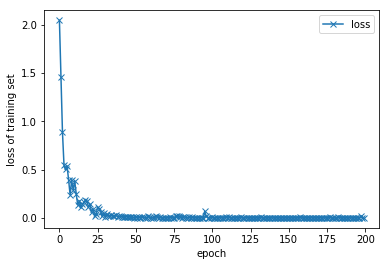

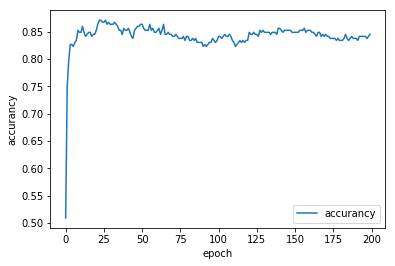

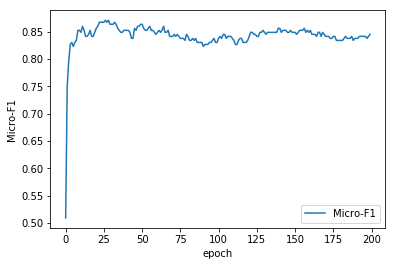

In [10]:
#plt.figure()
#plt.subplot("211")
plt.plot(epoch_record,loss_record,marker='x')
plt.xlabel("epoch")
plt.ylabel("loss of training set")
plt.legend(["loss"])
plt.show()
#plt.subplot("212")
plt.plot(epoch_record,accurancy_record)
plt.xlabel("epoch")
plt.ylabel("accurancy")
plt.legend(["accurancy"])
plt.show()
plt.plot(epoch_record,micro_f1)
plt.xlabel("epoch")
plt.ylabel("Micro-F1")
plt.legend(["Micro-F1"])
plt.show()